In [1]:
import numpy as np
import h5py, json, os
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

## Some parameters (tweak as you like)

In [2]:
graph_verbosity = True    # If set to true, graphs will be plotted

f0 = 60e9       	# radar operating frequency
c = 3e8             # speed of light
wavelength = c/f0   # radar wavelength

Rmin = 0.3          # min distance
Rmax = 0.6          # max distance

Tt = 30             # Np/Fs, total time taken for measurement
Fs = 2*f0/1e6       # sampling frequency

rangeList = np.arange(int(Rmin*100), int(Rmax*100)+1, 10)   # Distance range (do not change)

## Read the h5 file
`radarData` contains a `complex128` dtype array with dimensions (Nframes, NTS).

In [3]:
root_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'radar_data', '2021_09_22_new_gestures')

def parse_h5_folder(root_dir, dir_path):
    dir_path = os.path.join(root_dir, dir_path)
    h5_files = [path for path in os.listdir(dir_path) if path.endswith('.h5')]
    radarDataOneGesture = []
    for file_path in h5_files:
        hf = h5py.File(os.path.join(dir_path, file_path), 'r')
        radarDataOneGesture.append(np.squeeze(np.array(hf['/data'])))
        hf.close()
    return radarDataOneGesture

all_dir = [sub_dir for sub_dir in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, sub_dir))]

radarDataAll = []
labels = []
label_words = ['push', 'rolling', 'pinching', 'swing']

for label, dir_path in enumerate(all_dir):
    print(dir_path)
    radarDataAll.append(parse_h5_folder(root_dir, dir_path))
    labels.append([label for _ in range(len(radarDataAll[0]))])

radarDataAll = np.array(radarDataAll)
labels = np.array(labels)

Ngestures, Nsamples, Nframes, NTS = radarDataAll.shape
print(radarDataAll.shape, labels.shape)


Gesture 1 - Push
Gesture 2 - Rolling Forward
Gesture 3 - Pinching
Gesture 4 - Swing
(4, 10, 64, 621) (4, 10)


## Magnitude Plot / Output Signal Profile
The magnitude of the signal can found using `np.abs(radarData).T`, the tranpose function is to align the time axis correctly.

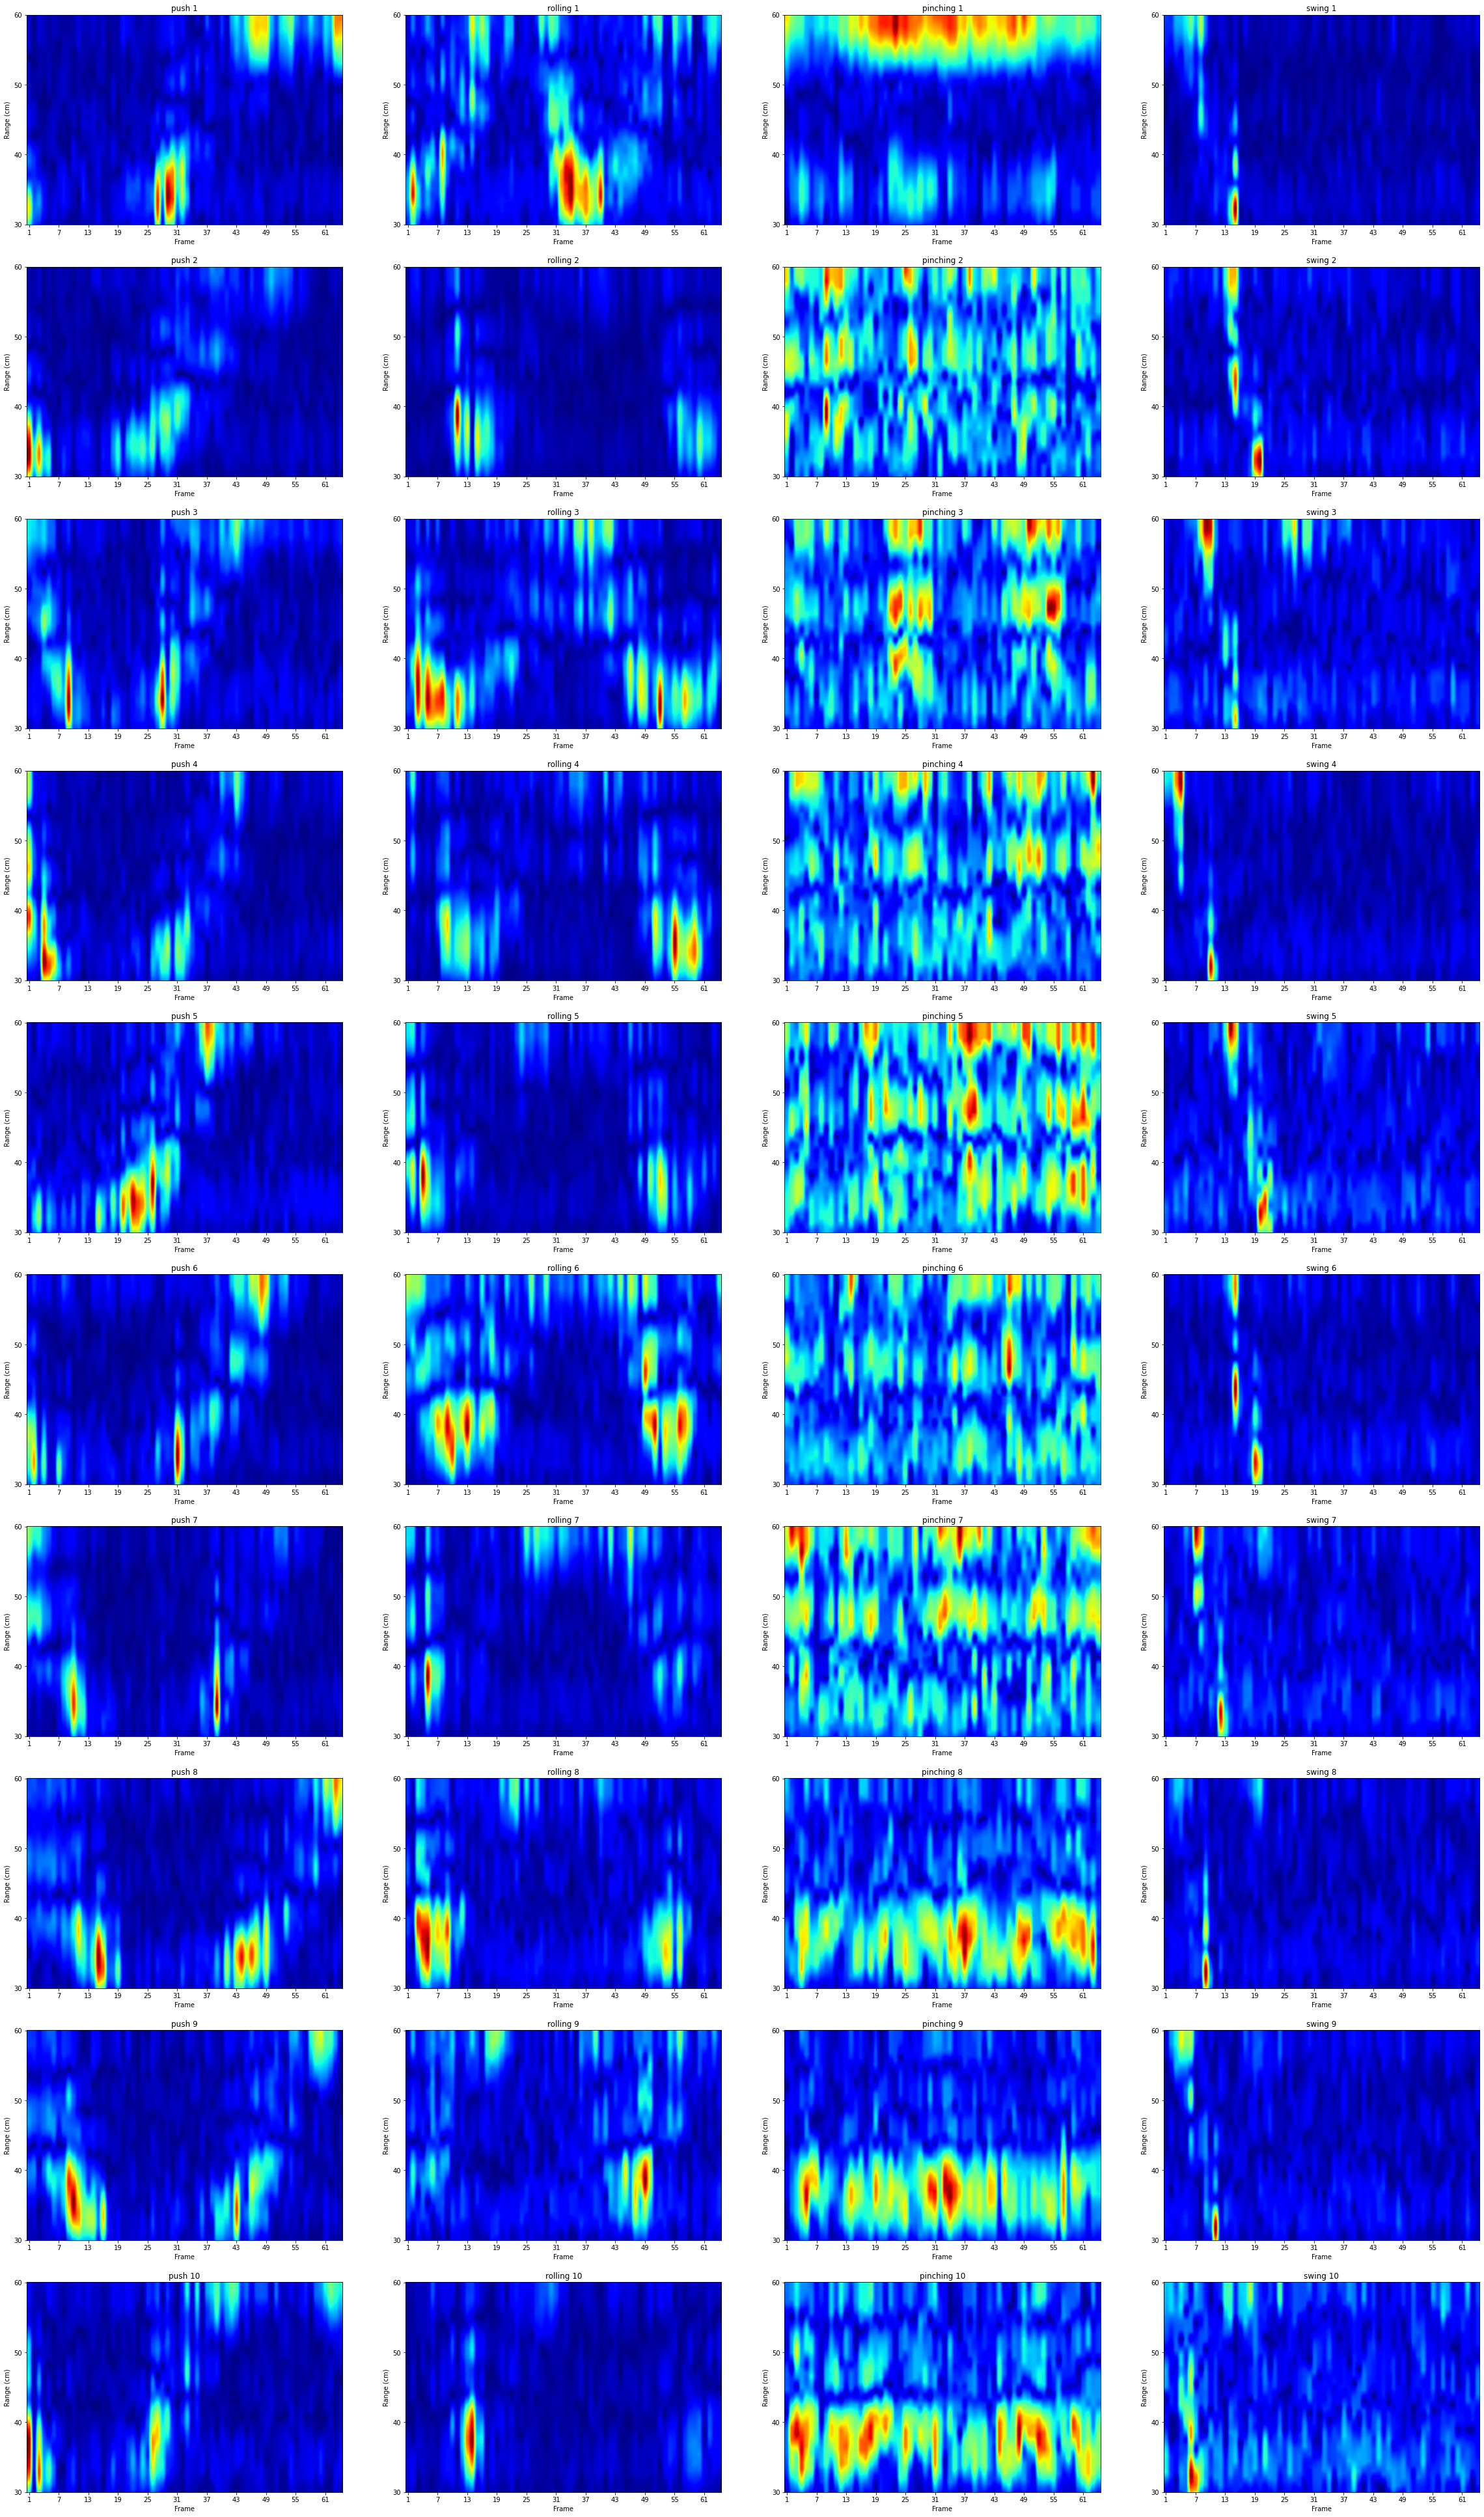

In [4]:
fig, axes = plt.subplots(10, 4, figsize=(40, 70))

# Predefine x and y ticks beforehand
xticks = np.arange(0, Nframes, Nframes//10)
yticks = np.linspace(0, NTS-1, rangeList.shape[0])

for i in range(4):
    for j in range(10):

        magnitudeData = np.abs(radarDataAll[i,j,:,:]).T
        normalizedMagnitudeData = magnitudeData / np.max(magnitudeData)
        ax = axes[j][i]

        ax.imshow(normalizedMagnitudeData, aspect='auto', origin='lower', cmap='jet');
        # plt.colorbar();
        ax.set_title(f'{label_words[labels[i,j]]} {j+1}');
        ax.set_xlabel('Frame'); ax.set_ylabel('Range (cm)');
        ax.set_xticks(xticks); ax.set_xticklabels(xticks+1);
        ax.set_yticks(yticks); ax.set_yticklabels(rangeList);
        
        np.save(f'plots_exported/{label_words[labels[i,j]]}-{str(j+1).zfill(2)}.npy', magnitudeData)

In [16]:
import numpy as np
import h5py, os

root_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), '2021_09_22_new_gestures')

def parse_h5_folder(root_dir, dir_path):
    dir_path = os.path.join(root_dir, dir_path)
    h5_files = [path for path in os.listdir(dir_path) if path.endswith('.h5')]
    radarDataOneGesture = []
    for file_path in h5_files:
        hf = h5py.File(os.path.join(dir_path, file_path), 'r')
        radarDataOneGesture.append(np.squeeze(np.array(hf['/data'])).T)
        hf.close()
    return radarDataOneGesture

all_dir = [sub_dir for sub_dir in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, sub_dir))]

radarDataAll = []
labels = []
label_words = ['push', 'rolling', 'pinching', 'swing']

for label, dir_path in enumerate(all_dir):
    print(dir_path)
    radarDataAll.append(parse_h5_folder(root_dir, dir_path))
    labels.append([label for _ in range(len(radarDataAll[0]))])

radarDataAll = np.array(radarDataAll)
labels = np.array(labels)

Ngestures, Nsamples, NTS, Nframes= radarDataAll.shape
print(radarDataAll.shape, labels.shape, end='\n\n')

radarDataMagnitude = np.abs(radarDataAll.reshape(-1, NTS*Nframes))
finalLabels = labels.reshape(-1)

print('Input features shape:', radarDataMagnitude.shape)
print('Labels shape:', finalLabels.shape)

Gesture 1 - Push
Gesture 2 - Rolling Forward
Gesture 3 - Pinching
Gesture 4 - Swing
(4, 10, 621, 64) (4, 10)

Input features shape: (40, 39744)
Labels shape: (40,)


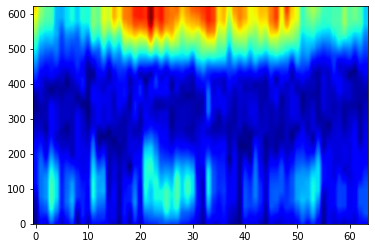

In [14]:
plt.imshow(radarDataMagnitude[20, :].reshape(NTS, Nframes), aspect='auto', origin='lower', cmap='jet');
## Matches 1st photo